In [1]:
import os, random
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
import torch

# Define a tensor with requires_grad=True to track computation
x = torch.ones((1, 2, 4))

# Define a function y = x^2
y = (x ** 2).sum()

# Compute the gradient dy/dx
grad = torch.autograd.grad(outputs=y, inputs=x)

print("Gradient:", grad[0])  # Should print 4.0

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [2]:
data_path = Path('data/separated_night_day')#../../data/separated_night_day/day/train

# Utils

In [3]:
@torch.no_grad()
def show_day_night_samples(day_ddpm, night_ddpm,
                           n_samples = 4,
                           img_size = None,
                           device = "cuda",
                           save_path = None):
    """
    Draws a 2‑row grid:
        first row  – `n_samples` from the *day* DDPM
        second row – `n_samples` from the *night* DDPM

    Args
    ----
    day_ddpm, night_ddpm : your trained models (exposed by the trainers)
    n_samples            : how many samples per row (default 4)
    img_size             : override the DDPM's native image size (keeps original if None)
    device               : where to run the sampler
    save_path            : if given, writes the grid PNG to this path
    """
    day_ddpm.eval().to(device)
    night_ddpm.eval().to(device)

    # -- sample --------------------------------------------------------
    x_day   = day_ddpm.sample(batch_size=n_samples).clamp(0, 1)    # [B,3,H,W] in [0,1]
    x_night = night_ddpm.sample(batch_size=n_samples).clamp(0, 1)

    if img_size is not None:
        import torch.nn.functional as F
        h, w = (img_size, img_size) if isinstance(img_size, int) else img_size
        x_day   = F.interpolate(x_day,   size=(h, w), mode="bilinear", align_corners=False)
        x_night = F.interpolate(x_night, size=(h, w), mode="bilinear", align_corners=False)

    # -- build a 2×n grid ---------------------------------------------
    #   cat rows, then make_grid puts them into one image
    grid = make_grid(torch.cat([x_day, x_night], dim=0),
                     nrow=n_samples, pad_value=1.0)

    # -- plot ----------------------------------------------------------
    plt.figure(figsize=(n_samples * 2.5, 5))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu())   # CHW -> HWC
    plt.title(f"{n_samples} samples – Day (top) | Night (bottom)")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [4]:
def count_parameters(model):
    import numpy as np
    model_parameters = filter(lambda p: p.requires_grad,  model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

# Load DDPMs

In [5]:
import sys
sys.path.append('../')
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

In [6]:
mults = (1, 2, 4)
mults_str = '_'.join(str(m) for m in mults)

In [7]:
model = Unet(
    dim = 64,
    dim_mults =mults, 
    flash_attn = True)

diffusion = GaussianDiffusion(model, image_size = 64, timesteps=1000)

day_folder = "../ddpm/results/day/1_2_4/tr_stp_70000_stp1000/2025_07_20_22_40"
night_folder = "../ddpm/results/night/1_2_4/tr_stp_70000_stp1000/2025_07_21_06_55"


day_trainer = Trainer( diffusion, data_path/'day'/'train', results_folder=day_folder, calculate_fid = False)
night_trainer = Trainer( diffusion, data_path/'day'/'train', results_folder=night_folder, calculate_fid = False)

A100 GPU detected, using flash attention if input tensor is on cuda


AssertionError: you should have at least 100 images in your folder. at least 10k images recommended

In [8]:
day_trainer.load(10)
night_trainer.load(10)

NameError: name 'day_trainer' is not defined

In [31]:
count_parameters(day_ddpm), count_parameters(night_ddpm)

(9904515, 9904515)

In [23]:
day_ddpm = day_trainer.model
night_ddpm = night_trainer.model

sampling loop time step:   0%|          | 0/5000 [00:00<?, ?it/s]/NAS/PROJECTS/BOMRGD/envs/ddpm_env/lib/python3.8/contextlib.py:83: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
sampling loop time step: 100%|██████████| 5000/5000 [00:50<00:00, 98.31it/s] 


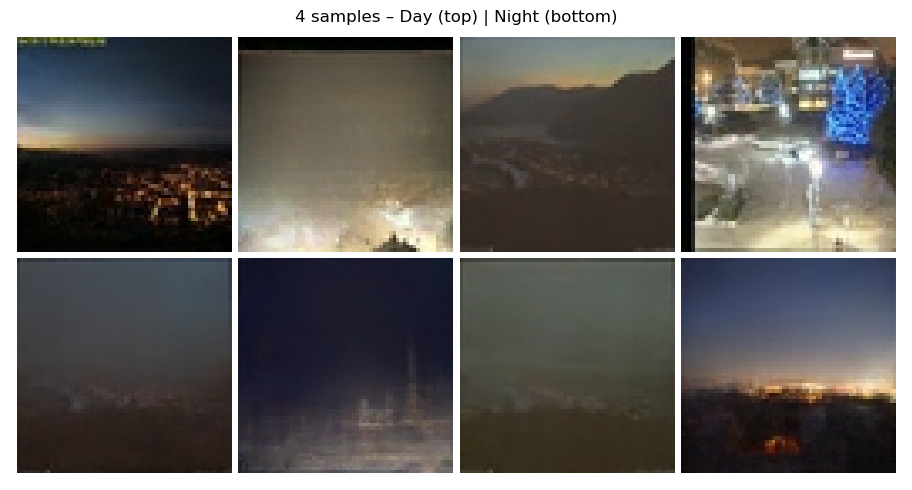

In [66]:
show_day_night_samples(day_ddpm, night_ddpm)

# Discriminator

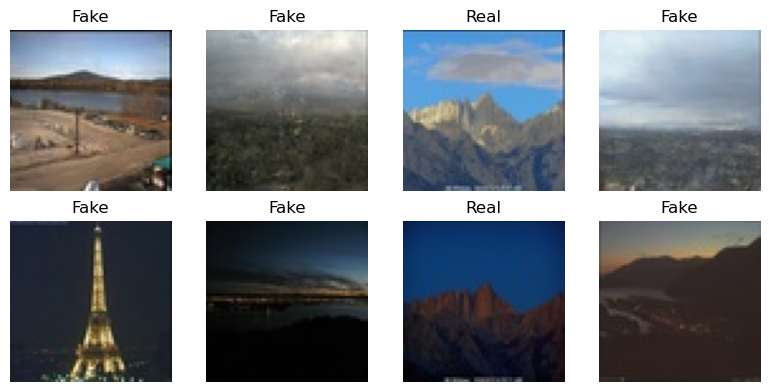

In [14]:
import random, itertools
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1.  Joint-vs-Independent dataset
# -------------------------------------------------
class MMDiscoDiscriminatorDataset(Dataset):
    """
    Returns a 3-tuple
        (day_tensor, night_tensor, label)
    where label = 1  →  real *paired* (x_t, y_t)
          label = 0  →  fake *independent* pair
    """
    _exts = {".png", ".jpg", ".jpeg", ".bmp"}

    def __init__(self,
                 real_root,                   # ../../data/separated_night_day
                 fake_day_dir,                # ../ddpm/samples/day/…
                 fake_night_dir,              # ../ddpm/samples/night/…
                 image_size=64,
                 p_real=0.5,                  # prob of returning a real pair
                 split="train"):
        super().__init__()

        # ----------- real paired ids ---------------
        real_root = Path(real_root)
        self.day_dir   = real_root / "day"   / split
        self.night_dir = real_root / "night" / split

        ids_day = {p.stem.rsplit("_day", 1)[0] for p in self.day_dir.iterdir()
                   if p.suffix.lower() in self._exts}
        ids_night = {p.stem.rsplit("_night", 1)[0] for p in self.night_dir.iterdir()
                     if p.suffix.lower() in self._exts}
        self.real_ids = sorted(ids_day & ids_night)
        if not self.real_ids:
            raise RuntimeError("No paired real images found!")

        # ----------- fake marginals ----------------
        self.fake_day_paths   = sorted([p for p in Path(fake_day_dir).iterdir()
                                        if p.suffix.lower() in self._exts])
        self.fake_night_paths = sorted([p for p in Path(fake_night_dir).iterdir()
                                        if p.suffix.lower() in self._exts])
        if not self.fake_day_paths or not self.fake_night_paths:
            raise RuntimeError("No fake images found in the supplied folders")

        # ----------- transforms --------------------
        self.tf = T.Compose([
            T.Resize(image_size),
            T.CenterCrop(image_size),
            T.ToTensor()                # [0,1]
        ])

        # sampling probability
        self.p_real = p_real

    def __len__(self):
        # make an epoch roughly as long as the real dataset
        return len(self.real_ids)

    def _load_img(self, path):
        return self.tf(Image.open(path).convert("RGB"))

    # -------------- main --------------------------
    def __getitem__(self, idx):
        if random.random() < self.p_real:
            # -------- real paired example ----------
            id_ = self.real_ids[idx % len(self.real_ids)]
            day   = self._load_img(self.day_dir   / f"{id_}_day.jpg")
            night = self._load_img(self.night_dir / f"{id_}_night.jpg")
            label = 1
        else:
            # -------- fake independent example -----
            day_path   = random.choice(self.fake_day_paths)
            night_path = random.choice(self.fake_night_paths)
            day   = self._load_img(day_path)
            night = self._load_img(night_path)
            label = 0

        return day, night, torch.tensor(label, dtype=torch.float32)

# -------------------------------------------------
# 2.  Helper that builds the torch.DataLoader
# -------------------------------------------------
def get_discriminator_loader(real_root,
                             fake_day_dir,
                             fake_night_dir,
                             batch_size=32,
                             image_size=64,
                             num_workers=4,
                             pin_memory=True,
                             p_real=0.5):
    ds = MMDiscoDiscriminatorDataset(real_root,
                                     fake_day_dir,
                                     fake_night_dir,
                                     image_size=image_size,
                                     p_real=p_real)
    return DataLoader(ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=pin_memory)

# -------------------------------------------------
# 3.  Visual sanity-check (plot 8 samples)
# -------------------------------------------------
def show_joint_vs_independent(loader, n_samples=8):
    day_img, night_img, labels = next(iter(loader))
    day_img   = day_img[:n_samples]
    night_img = night_img[:n_samples]
    labels    = labels[:n_samples]

    grid = torch.cat([day_img, night_img], dim=0)      # 2×n grid
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))
    axes = axes.flatten()
    for i, (ax, img, lb) in enumerate(zip(axes, grid, torch.cat([labels, labels]))):
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"{'Real' if lb==1 else 'Fake'}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

# ------------------- usage ------------------------
loader = get_discriminator_loader(
    real_root="../../data/separated_night_day",
    fake_day_dir ="../ddpm/samples/day/1_2_4/tr_stp_70000_stp1000/2025_07_20_22_40",
    fake_night_dir="../ddpm/samples/night/1_2_4/tr_stp_70000_stp1000/2025_07_21_06_55",
    batch_size=32)

show_joint_vs_independent(loader, n_samples=4)


In [43]:
# --------------------------------------------
# Discriminator  (≈ 1.0 M params with base=48)
# --------------------------------------------
import math, torch
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Two tiny CNN encoders → GAP → concat → MLP → *logit*  (no sigmoid!)
    """
    def __init__(self, in_ch=3, base=48, n_steps=1000):
        super().__init__()

        def enc():
            return nn.Sequential(
                nn.Conv2d(in_ch,   base,   4, 2, 1), nn.SiLU(),                            # 64→32
                nn.Conv2d(base,  base*2, 4, 2, 1), nn.GroupNorm(8, base*2), nn.SiLU(),      # 32→16
                nn.Conv2d(base*2, base*4, 4, 2, 1), nn.GroupNorm(8, base*4), nn.SiLU(),     # 16→8
                nn.AdaptiveAvgPool2d(1),                                                   # (B,C,1,1)
                nn.Flatten())                                                              # (B, base*4)

        self.enc_x = enc()
        self.enc_y = enc()
        self.t_embed = nn.Embedding(n_steps, base * 4)

        self.head = nn.Sequential(
            nn.Linear(base * 12, base * 4),  # (x + y + t) = 3×(base*4)
            nn.SiLU(),
            nn.Linear(base * 4, 1))          # raw logit

        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))

    # -- forward returns *logits* --
    def forward(self, x_t, y_t, t):
        h = torch.cat([self.enc_x(x_t),
                       self.enc_y(y_t),
                       self.t_embed(t)], dim=1)
        return self.head(h).squeeze(1)        # (B,)  logits


In [44]:
D = Discriminator()
count_parameters(D)

1046689

In [45]:
# --------------------------------------------
# Training loop  (AMP-safe, BCEWithLogits)
# --------------------------------------------
import torch, random
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler     # new API (torch ≥2.2)

def train_discriminator(day_ddpm,
                        night_ddpm,
                        disc_loader: DataLoader,
                        num_steps=50_000,
                        lr=1e-4,
                        device="cuda",
                        save_every=10_000,
                        ckpt_path="disc_mm_disco.pt"):

    day_ddpm.eval().requires_grad_(False)
    night_ddpm.eval().requires_grad_(False)

    D   = Discriminator().to(device)
    opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    scaler = GradScaler()

    loader_it = iter(disc_loader)
    bce_logits = torch.nn.BCEWithLogitsLoss()

    for step in range(1, num_steps + 1):
        # ---------- fetch batch (re-cycle at epoch end) ----------
        try:
            day_img, night_img, labels = next(loader_it)
        except StopIteration:
            loader_it = iter(disc_loader)
            day_img, night_img, labels = next(loader_it)

        day_img   = day_img.to(device)          # [0,1]
        night_img = night_img.to(device)
        labels    = labels.to(device)           # 0 or 1, float32

        B = day_img.size(0)
        t = torch.randint(0, 1000, (B,), device=device).long()

        # ---------- forward-diffuse ----------
        eps_x = torch.randn_like(day_img)
        eps_y = torch.randn_like(night_img)
        x_t   = day_ddpm.q_sample(day_img,   t, eps_x)
        y_t   = night_ddpm.q_sample(night_img, t, eps_y)

        # ---------- discriminator forward ----------
        with autocast(device_type="cuda"):
            logits  = D(x_t, y_t, t)                          # raw
            L_disc  = bce_logits(logits, labels)              # BCE w/ logits

        # ---------- denoising regulariser ----------
        # log(p/(1-p)) == logits
        ratio = logits
        grad_x, grad_y = torch.autograd.grad(ratio.sum(),
                                             (x_t, y_t),
                                             create_graph=True)

        eps_pred_x = day_ddpm.model(x_t, t)
        eps_pred_y = night_ddpm.model(y_t, t)

        c_t = day_ddpm.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        L_denoise = ((eps_x - eps_pred_x + c_t * grad_x) ** 2).mean() + \
                    ((eps_y - eps_pred_y + c_t * grad_y) ** 2).mean()

        loss = L_disc + L_denoise

        # ---------- optim step ----------
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        # ---------- logging ----------
        if step % 500 == 0:
            print(f"step {step:6d} | L_disc {L_disc.item():.3f} "
                  f"| L_den {L_denoise.item():.3f}")

        # ---------- checkpoint ----------
        if step % save_every == 0:
            torch.save({"step": step,
                        "state_dict": D.state_dict(),
                        "opt": opt.state_dict()},
                       ckpt_path)

    print("⇨ discriminator training finished")
    return D


# Train

In [ ]:
# --- 1. data loader (from previous answer) ---
loader = get_discriminator_loader(
    real_root="../../data/separated_night_day",
    fake_day_dir ="../ddpm/samples/day/1_2_4/tr_stp_70000_stp1000/2025_07_20_22_40",
    fake_night_dir="../ddpm/samples/night/1_2_4/tr_stp_70000_stp1000/2025_07_21_06_55",
    batch_size=32, image_size=64)

# --- 2. frozen DDPMs ---
day_ddpm   = day_trainer.model.to("cuda").eval()
night_ddpm = night_trainer.model.to("cuda").eval()

# --- 3. train ---
disc = train_discriminator(day_ddpm,
                           night_ddpm,
                           loader,
                           num_steps=60_000,    # ≈ 100 epochs
                           device="cuda")


# Joint sampling 

In [70]:
@torch.no_grad()
def joint_ddpm_sample(day_ddpm, night_ddpm, D, n=16, device="cuda"):
    h,w = day_ddpm.image_size
    xt  = torch.randn(n, 3, h, w, device=device)
    yt  = torch.randn_like(xt)

    for t in reversed(range(day_ddpm.num_timesteps)):
        tt = torch.full((n,), t, device=device, dtype=torch.long)

        # discriminator ratio & gradients
        xt.requires_grad_(); yt.requires_grad_()
        ratio = (torch.log(D(xt,yt,tt)+1e-8) - torch.log(1-D(xt,yt,tt)+1e-8)).sum()
        grad_x, grad_y = torch.autograd.grad(ratio, (xt,yt))

        # corrected noises
        eps_x = day_ddpm.model(xt, tt)  - day_ddpm.sqrt_one_minus_alphas_cumprod[t]*grad_x
        eps_y = night_ddpm.model(yt, tt)- night_ddpm.sqrt_one_minus_alphas_cumprod[t]*grad_y

        # DDPM posterior step (uses µ = xₜ − βₜ/√(1-ᾱₜ)·eps) 
        xt = day_ddpm.p_sample_from_eps(xt, tt, eps_x)       # wrap this util from your code‑base
        yt = night_ddpm.p_sample_from_eps(yt, tt, eps_y)

    return day_ddpm.unnormalize(xt), night_ddpm.unnormalize(yt)


In [ ]:
# 1. load the two *pre‑trained* DDPMs you already have
day_ddpm.to("cuda").eval()
night_ddpm.to("cuda").eval()

# 2. prepare paired loader for the discriminator
train_dl,_ = get_daynight_pair_loaders(
                 root="../../data/separated_night_day", batch_size=32, image_size=64)

# 3. train the discriminator (≈ a few hours on one GPU)
D = train_discriminator(day_ddpm, night_ddpm, train_dl)

# 4. joint sampling
x_out, y_out = joint_ddpm_sample(day_ddpm, night_ddpm, D, n=16)
utils.save_image(torch.cat([x_out,y_out]), "joint_grid.png", nrow=16)
